In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
features = pd.read_csv(os.path.join('..', "..","fma_metadata", "features.csv"), 
                       index_col=[0], 
                       header=[0,1,2])

In [4]:
tracks = pd.read_csv(os.path.join("..", "..", "fma_metadata", "tracks.csv"), 
                     index_col=[0], 
                     header=[0,1])

In [5]:
genres = pd.read_csv(os.path.join("..", "..", "fma_metadata", "genres.csv"))

In [7]:
tracks['Rock'] = tracks.track.genres.apply(lambda x: True if ('12' in x) else False )
Rock_features = features[tracks['Rock'] == True].reset_index(drop=True)

tracks['Hiphop'] = tracks.track.genres.apply(lambda x: True if ('21' in x) else False )
Hiphop_features = features[tracks['Hiphop'] == True].reset_index(drop=True)

tracks['Electronic'] = tracks.track.genres.apply(lambda x: True if ('15' in x) else False )
Electronic_features = features[tracks['Electronic'] == True].reset_index(drop=True)

tracks['Folk'] = tracks.track.genres.apply(lambda x: True if ('17' in x) else False )
Folk_features = features[tracks['Folk'] == True].reset_index(drop=True)

In [62]:
n_sample = min([len(Folk_features),len(Electronic_features),len(Hiphop_features),len(Rock_features)])
f_sample = Folk_features.sample(n = n_sample).reset_index(drop=True)
e_sample = Electronic_features.sample(n = n_sample).reset_index(drop=True)
r_sample = Rock_features.sample(n = n_sample).reset_index(drop=True)
h_sample = Hiphop_features.sample(n = n_sample).reset_index(drop=True)

X = pd.concat([f_sample,e_sample,r_sample,h_sample]).reset_index(drop=True)
X.columns = X.columns.get_level_values(0)
X = X.to_numpy()

labels = np.concatenate((np.zeros(n_sample), np.ones(n_sample),np.full(n_sample, 2),np.full(n_sample, 3)), axis=0)

In [63]:
len(labels)

23828

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [66]:
type(X)

numpy.ndarray

In [92]:
import numpy as np
from random import sample

random_idx = np.random.choice([i for i in range(len(X))], 2000)
X = X[random_idx]

pfa = PFA(n_features=2)
pfa.fit(X)

# To get the transformed matrix
X = pfa.features_

# To get the column indices of the kept features
column_indices = pfa.indices_

In [93]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.preprocessing import scale

af = AffinityPropagation(damping=0.9, convergence_iter=2).fit(X)


In [94]:
cluster_centers_indices = af.cluster_centers_indices_
labels = labels[random_idx]
n_clusters_ = len(cluster_centers_indices)

In [98]:
centroids

array([ 105,  272,  339,  368,  382,  574,  650,  889, 1153, 1270, 1287,
       1443, 1661, 1866])

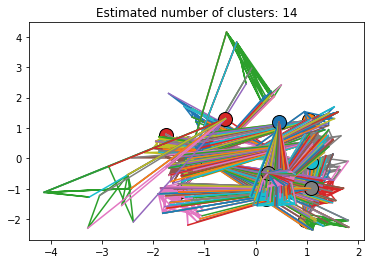

In [95]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

#colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k in range(n_clusters_):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1])#, col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markeredgecolor='k', markersize=14)#, markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]])#, col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [96]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))

Homogeneity: 0.637
Completeness: 0.802
V-measure: 0.710


In [10]:
results = pd.DataFrame()
results['folk'] = np.concatenate((np.ones(n_sample),np.zeros(n_sample),np.zeros(n_sample),np.zeros(n_sample)))
results['electronic'] = np.concatenate((np.zeros(n_sample),np.ones(n_sample),np.zeros(n_sample),np.zeros(n_sample)))
results['rock'] = np.concatenate((np.zeros(n_sample),np.zeros(n_sample),np.ones(n_sample),np.zeros(n_sample)))
results['hiphop'] = np.concatenate((np.zeros(n_sample),np.zeros(n_sample),np.zeros(n_sample),np.ones(n_sample)))
results['pred'] = kmeans.labels_
#results['ones'] = np.full(n_sample*4, 1)
results = results.groupby(['pred']).sum()
results

,folk,electronic,rock,hiphop
pred,,,,
0,574.0,1639.0,1943.0,1493.0
1,1741.0,677.0,1083.0,219.0
2,1107.0,2818.0,1458.0,3924.0
3,2535.0,823.0,1473.0,321.0


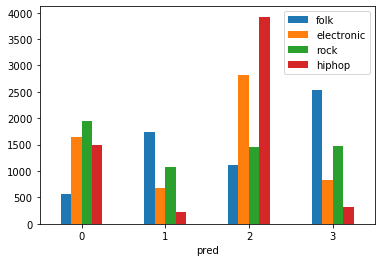

In [11]:
results.plot.bar(rot=0)